In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import tqdm
import pickle

### Training

In [6]:
data = np.load('data_all.npz')
trainv = data['trainv']
testv = data['testv']
trainlab = data['trainlab']
testlab = data['testlab']

In [3]:
def predict(train_vec, train_lab, test_vec):
    # Compute Euclidean distances
    distances = cdist(test_vec, train_vec,metric='euclidean')
    # Find the nearest neighbor
    nearest_idx = np.argmin(distances,axis=1)
    return train_lab[nearest_idx]

In [4]:
total_tests = testv.shape[0]
predictions = []
for i in tqdm.tqdm(range(int(total_tests/1000))):
    test_batch = testv[i*1000:(i+1)*1000]

    batch_pred = predict(trainv, trainlab, test_batch)

    predictions.append(batch_pred)

predictions = np.concatenate(predictions)
predictions.shape

100%|██████████| 10/10 [03:45<00:00, 22.57s/it]


(10000,)

The above function ran for 4m 44.9s

In [ ]:
# Save predictions to file
with open('predictions/mnist_NN_predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)

NameError: name 'predictions' is not defined

### Looking

In [ ]:
# Load predictions
with open('predictions/mnist_NN_predictions.pkl', 'rb') as f:
    predictions = pickle.load(f)

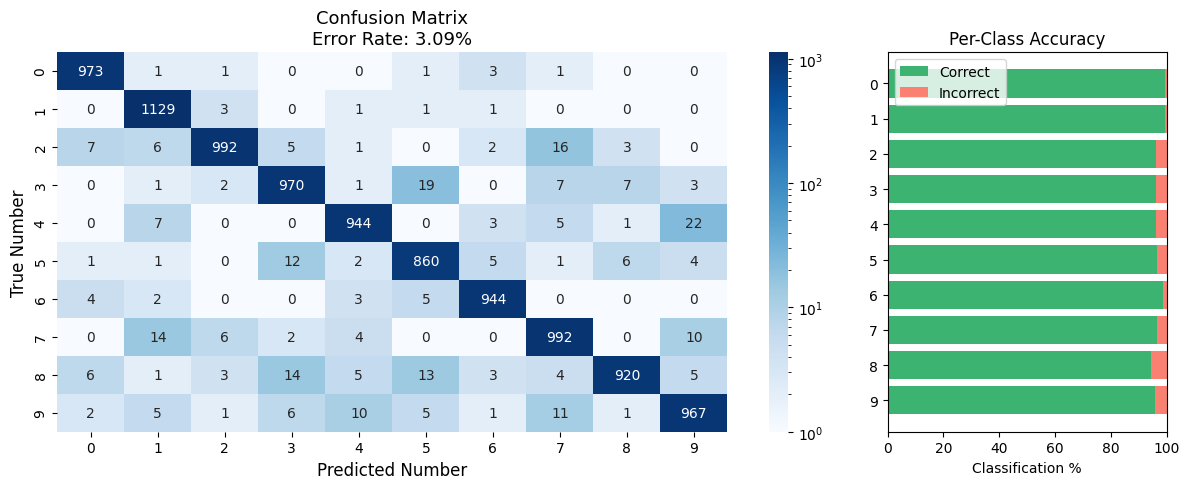

In [ ]:
if predictions.shape != testlab.shape:
    assert("shapes dont match")


conf_matrix = np.zeros((10,10),dtype=int)
for i in range(predictions.shape[0]):
    conf_matrix[testlab[i],predictions[i]] += 1


labels = np.arange(10).astype(str)

total_sum = np.sum(conf_matrix)
diag_sum = np.trace(conf_matrix)
err_rate = round((total_sum-diag_sum)/total_sum,4)*100


from matplotlib.colors import LogNorm

# True Positives: diagonal
true_positives = np.diag(conf_matrix)

# Total samples per class (sum of rows)
class_totals = np.sum(conf_matrix, axis=1)

# Avoid division by zero
class_accuracy = np.divide(true_positives, class_totals, out=np.zeros_like(true_positives, dtype=float), where=class_totals!=0)

# Convert to percentage
class_accuracy_percent = np.round(class_accuracy * 100, 2)
class_error_percent = 100 - class_accuracy_percent


# Shifted matrix for log color
conf_matrix_safe = conf_matrix + 1

fig, ax = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [3, 1]})

# Confusion Matrix
sns.heatmap(conf_matrix_safe, annot=conf_matrix, fmt='d',
            cmap='Blues', norm=LogNorm(vmin=1, vmax=conf_matrix_safe.max()),
            xticklabels=labels, yticklabels=labels, ax=ax[0])

ax[0].set_xlabel("Predicted Number", fontsize=12)
ax[0].set_ylabel("True Number", fontsize=12)
ax[0].set_title(f"Confusion Matrix\nError Rate: {err_rate}%", fontsize=13)

# Bar Plot: Accuracy per class
ax[1].barh(labels, class_accuracy_percent, color='mediumseagreen', label='Correct')
ax[1].barh(labels, class_error_percent, left=class_accuracy_percent, color='salmon', label='Incorrect')

ax[1].set_xlim(0, 100)
ax[1].set_xlabel("Classification %")
ax[1].set_title("Per-Class Accuracy")
ax[1].legend(loc='upper left')
ax[1].invert_yaxis()  

plt.tight_layout()
plt.show()

In [12]:
wrong_idx = []
correct_idx = []
for i in range(predictions.shape[0]):
    if predictions[i] != testlab[i]:
        wrong_idx.append(i)
    else:
        correct_idx.append(i)



Predicted = 3, True label = 5


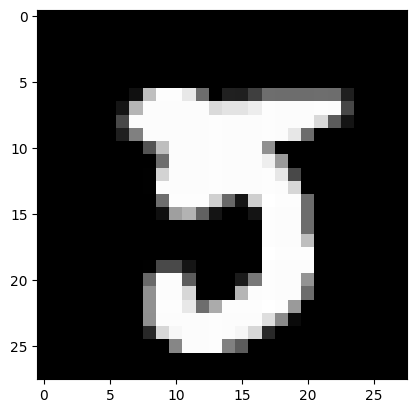

Predicted = 8, True label = 2


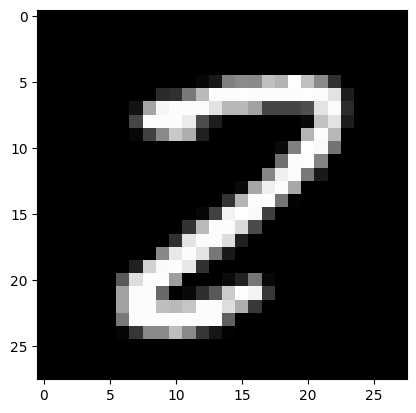

Predicted = 0, True label = 6


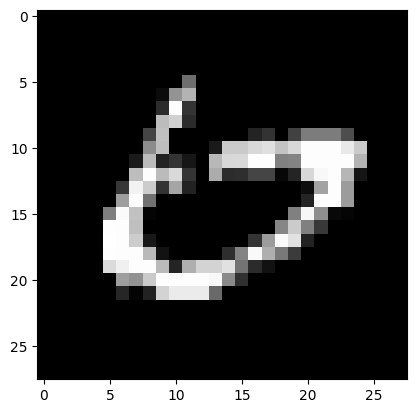

Predicted = 9, True label = 4


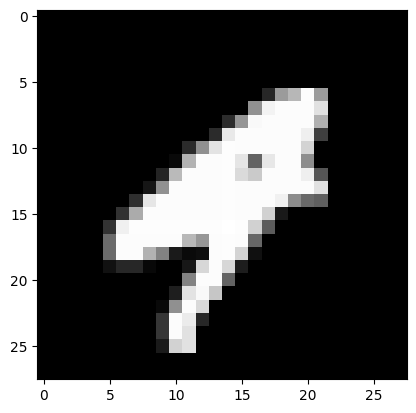

Predicted = 7, True label = 3


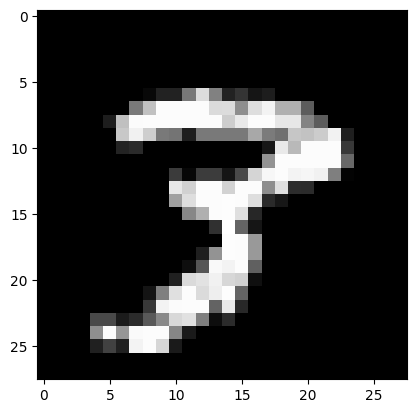

In [10]:
for i in range(10,15):
    im_idx = wrong_idx[i]

    print(f"Predicted = {predictions[im_idx]}, True label = {testlab[im_idx]}")
    x = testv[im_idx, :].reshape((28, 28))
    plt.imshow(x, cmap="gray")
    plt.show()

Predicted = 7, True label = 7


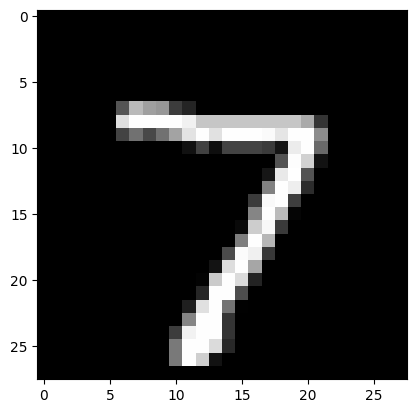

Predicted = 2, True label = 2


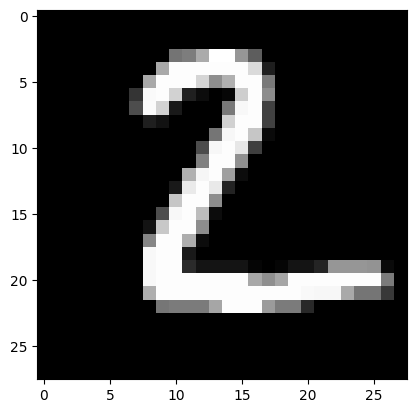

Predicted = 1, True label = 1


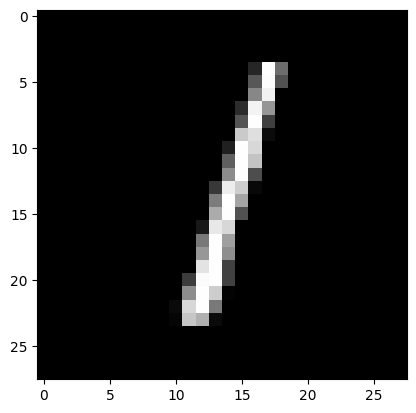

Predicted = 0, True label = 0


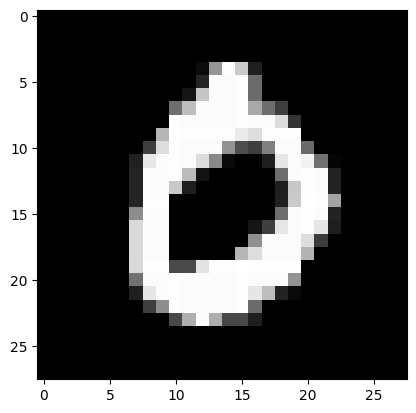

Predicted = 4, True label = 4


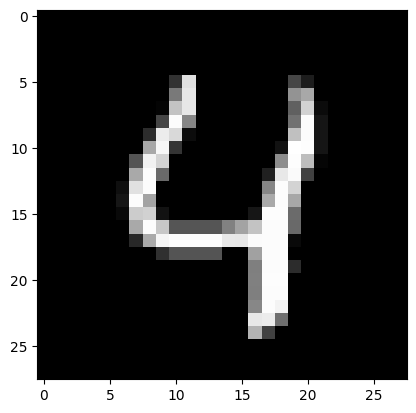

In [14]:
for i in range(0,5):
    im_idx = correct_idx[i]

    print(f"Predicted = {predictions[im_idx]}, True label = {testlab[im_idx]}")
    x = testv[im_idx, :].reshape((28, 28))
    plt.imshow(x, cmap="gray")
    plt.show()